### Курсовой проект

1. Обучить модель прогнозирования дохода человека (больше или меньше 50 тыс.долл.) на основе его личных характеристик
2. Создать rest api сервис, к которому можно будет обращаться для получения прогнозов

In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#from sklearn.feature_extraction.text import TfidfVectorizer
import itertools
import seaborn as sns
import category_encoders as ce
import dill

from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor, plot_tree, DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.metrics import r2_score as r2, mean_squared_error as mse, roc_auc_score, recall_score

from sklearn import svm
from sklearn.svm import SVR

import statsmodels.api as sm
import statsmodels.formula.api as smf

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from scipy.sparse import hstack
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier


from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix
import itertools

from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score

import matplotlib.pyplot as plt

%matplotlib inline

Title: База данных UCI взрослых. Предсказать, если доход> или <50 тыс. Долларов США на основе данных переписи

Attributes:
1. age		u  (16,Inf]	# Person's age
2. workclass   u Private Self-emp-not-inc Self-emp-inc Federal-gov  Local-gov State-gov Without-pay Never-worked # Work type
3. fnlwgt      u  [-Inf,Inf]	# ??
4. education   u Preschool 1st-4th 5th-6th 7th-8th 9th 10th 11th 12th HS-grad Assoc-acdm Assoc-voc Some-college Prof-school Bachelors Masters Doctorate # Education level
5. educational-num u [0,Inf] #
6. marital-status  u  Married-civ-spouse Divorced Never-married Separated Widowed Married-spouse-absent Married-AF-spouse	# 
7. occupation  u  Tech-support Craft-repair Other-service Sales Exec-managerial Prof-specialty Handlers-cleaners Machine-op-inspct Adm-clerical Farming-fishing Transport-moving Priv-house-serv Protective-serv Armed-Forces # 
8. relationship u Wife Own-child Husband Not-in-family Other-relative Unmarried	# 
9. race	 u  White Asian-Pac-Islander Amer-Indian-Eskimo Other Black
10. gender	 u  Female Male	# 
11. capital-gain u [0,Inf] #
12. capital-loss u [0,Inf] #
13. hours-per-week u [0,168] #
14. native-country u United-States Cambodia England Puerto-Rico Canada Germany Outlying-US(Guam-USVI-etc) India Japan Greece South China Cuba Iran Honduras Philippines Italy Poland Jamaica Vietnam Mexico Portugal Ireland France Dominican-Republic Laos Ecuador Taiwan Haiti Columbia Hungary Guatemala Nicaragua Scotland Thailand Yugoslavia El-Salvador Trinadad&Tobago Peru Hong Holand-Netherlands #
15. income	   u <=50K >50K # Income breakpoint

## Содержание
* [1. Общее описание датасета](#prep)
* [2. Целевая переменная](#target)
* [3. Признаки](#features)
* [4. Обработка датасета](#prepare)
* [5. Моделирование](#models)
* [6. Pipeline](#pipeline)
* [7. Проверка Pipeline](#check)
* [8. Проверка API Pipeline](#apicheck)


# 1. Общее описание датасета<a class='anchor' id='prep'>

In [2]:
data = 'Dataset.data'

In [3]:
df = pd.read_csv(data, sep=' ')

df.columns=["age", "workclass", "fnlwgt", "education", "educational-num", "marital-status", "occupation", "relationship", 
            "race", "gender", "capital-gain", "capital-loss", "hours-per-week", "native-country", "target_50k"]

In [4]:
df.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,target_50k
0,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
1,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
2,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
3,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K
4,34,Private,198693,10th,6,Never-married,Other-service,Not-in-family,White,Male,0,0,30,United-States,<=50K


Целью работы является построение модели прогнозирование дохода пользователя (больше или меньше 50 тыс долл) в зависимости от его личных параметров. 

Инструментом моделирования служат различные модели машинного обучения:
 - линейная регрессия (в т.ч. с регуляризацией если будет необходимо (при высокой автокорреляции));
 - дерево решений;
 - случайный лес;
 - gradient Boosting;
 - LGBMRegressor;
 - XGBRegressor... . 

Будут рассчитаны различные метрики качества моделей и выбрана наиболее оптимальная.

В качестве проверки будет сделана дополнительная валидационная выборка. 

Далее будет построен pipeline и оценено качество модели на дополнительной подвыборке данных.

Далее будет подготовлено api для возмодности удаленной работы с моделью.


## 2. Целевая переменная<a class='anchor' id='target'>

In [5]:
df.loc[(df['target_50k'] == '<=50K'), 'target_50k'] = 0
df.loc[(df['target_50k'] == '>50K'), 'target_50k'] = 1

In [6]:
df.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,target_50k
0,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,0
1,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,1
2,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,1
3,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,0
4,34,Private,198693,10th,6,Never-married,Other-service,Not-in-family,White,Male,0,0,30,United-States,0


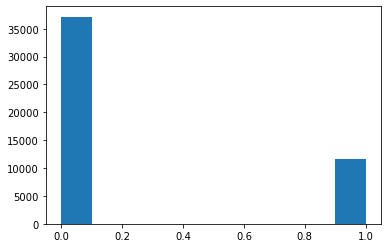

кол-во пропущенных значений 0


In [7]:
plt.hist(df['target_50k'], bins=None)
plt.show()
print('кол-во пропущенных значений', df['target_50k'].isnull().sum())

**Выводы:**

Имеется несбалансированность, при моделировании необходимо это учесть

## 3. Признаки<a class='anchor' id='features'>

In [8]:
df["age"].dtypes
#оставляем, потребуется стандартизация

dtype('int64')

In [9]:
df["workclass"].unique()
#кодируем auto-encoder

array(['Private', 'Local-gov', '?', 'Self-emp-not-inc', 'Federal-gov',
       'State-gov', 'Self-emp-inc', 'Without-pay', 'Never-worked'],
      dtype=object)

In [10]:
df["education"].unique()
#удаляем, как переменную используем следующей столбец

array(['HS-grad', 'Assoc-acdm', 'Some-college', '10th', 'Prof-school',
       '7th-8th', 'Bachelors', 'Masters', 'Doctorate', '11th', '5th-6th',
       'Assoc-voc', '9th', '12th', '1st-4th', 'Preschool'], dtype=object)

In [11]:
df["educational-num"].unique()
#связан с предыдущим, чем лучше образование, там больший рейтинг

array([ 9, 12, 10,  6, 15,  4, 13, 14, 16,  7,  3, 11,  5,  8,  2,  1],
      dtype=int64)

In [12]:
df["marital-status"].unique()
#кодируем auto-encoder

array(['Married-civ-spouse', 'Never-married', 'Widowed', 'Divorced',
       'Separated', 'Married-spouse-absent', 'Married-AF-spouse'],
      dtype=object)

In [13]:
df["occupation"].unique()
#кодируем auto-encoder

array(['Farming-fishing', 'Protective-serv', 'Machine-op-inspct', '?',
       'Other-service', 'Prof-specialty', 'Craft-repair', 'Adm-clerical',
       'Exec-managerial', 'Tech-support', 'Sales', 'Priv-house-serv',
       'Transport-moving', 'Handlers-cleaners', 'Armed-Forces'],
      dtype=object)

In [14]:
df["relationship"].unique()
#кодируем auto-encoder

array(['Husband', 'Own-child', 'Not-in-family', 'Unmarried', 'Wife',
       'Other-relative'], dtype=object)

In [15]:
df["race"].unique()
#кодируем auto-encoder

array(['White', 'Black', 'Asian-Pac-Islander', 'Other',
       'Amer-Indian-Eskimo'], dtype=object)

In [16]:
df["gender"].unique()
#male - 1, female - 0

array(['Male', 'Female'], dtype=object)

In [17]:
df["capital-gain"].dtypes
#оставляем, в дальнейшем потребуется стандартизация

dtype('int64')

In [18]:
df["capital-loss"].dtypes
#оставляем, в дальнейшем потребуется стандартизация

dtype('int64')

In [19]:
df["hours-per-week"].dtypes
#оставляем, в дальнейшем потребуется стандартизация

dtype('int64')

In [20]:
df["native-country"].unique()
#кодируем auto-encoder

array(['United-States', '?', 'Peru', 'Guatemala', 'Mexico',
       'Dominican-Republic', 'Ireland', 'Germany', 'Philippines',
       'Thailand', 'Haiti', 'El-Salvador', 'Puerto-Rico', 'Vietnam',
       'South', 'Columbia', 'Japan', 'India', 'Cambodia', 'Poland',
       'Laos', 'England', 'Cuba', 'Taiwan', 'Italy', 'Canada', 'Portugal',
       'China', 'Nicaragua', 'Honduras', 'Iran', 'Scotland', 'Jamaica',
       'Ecuador', 'Yugoslavia', 'Hungary', 'Hong', 'Greece',
       'Trinadad&Tobago', 'Outlying-US(Guam-USVI-etc)', 'France',
       'Holand-Netherlands'], dtype=object)

#### **Выводы**

К признакам
"workclass", "marital-status", "occupation", "relationship", "race", "native-country"

необхоимо применить CatBoostEncoder

Также необходимо изменить тип столбцов gender и target_50k

К столбцам 'age', 'educational-num', 'capital-gain', 'capital-loss', 'hours-per-week'
необходимо применить стандартизацию.

## 4. Обработка датасета<a class='anchor' id='prepare'>

In [21]:
cbe_encoder = ce.cat_boost.CatBoostEncoder()
scaler = StandardScaler()  

In [22]:
#функция для обработки тренингового датасета
class DataPreprocessing:
    """Подготовка исходных данных"""
    def transform(self, X):
        
        """Трансформация данных"""
        X.columns=["age", "workclass", "fnlwgt", "education", "educational-num", "marital-status", "occupation", "relationship", 
            "race", "gender", "capital-gain", "capital-loss", "hours-per-week", "native-country", "target_50k"]
        
        #target
        X.loc[(X['target_50k'] == '<=50K'), 'target_50k'] = 0
        X.loc[(X['target_50k'] == '>50K'), 'target_50k'] = 1
        X['target_50k'] = X['target_50k'].astype(np.float32)

        # пол
        X.loc[(X['gender'] == 'Male'), 'gender'] = 1
        X.loc[(X['gender'] == 'Female'), 'gender'] = 0
        X['gender'] = X['gender'].astype(np.float32)
        
        # text
        cbe_encoder.fit(X[["workclass", "marital-status", "occupation", "relationship", "race", "native-country"]], X['target_50k'])
        X_cbe = cbe_encoder.transform(X[["workclass", "marital-status", "occupation", "relationship", "race", "native-country"]])
        
        # data_itog
        X_data = X_cbe.join(X[["age", "educational-num", "gender", "capital-gain", 
                     "capital-loss", "hours-per-week", "target_50k"]])
              
        X_data[['age', 'educational-num', 'capital-gain', 'capital-loss', 'hours-per-week']] = scaler.fit_transform(X_data[['age', 'educational-num', 'capital-gain', 'capital-loss', 'hours-per-week']])
        
        return X_data



In [23]:
df = pd.read_csv(data, sep=' ')

data = DataPreprocessing().transform(df)

In [24]:
data.head()

,workclass,marital-status,occupation,relationship,race,native-country,age,educational-num,gender,capital-gain,capital-loss,hours-per-week,target_50k
0,0.217874,0.446123,0.116190,0.448661,0.253987,0.243982,-0.046962,-0.419362,1.0,-0.144805,-0.217129,0.772921,0.0
1,0.295582,0.446123,0.313251,0.448661,0.253987,0.243982,-0.776337,0.747529,1.0,-0.144805,-0.217129,-0.034087,1.0
2,0.217874,0.446123,0.123176,0.448661,0.120862,0.243982,0.390663,-0.030398,1.0,0.886862,-0.217129,-0.034087,1.0
3,0.094728,0.045495,0.094391,0.014673,0.253987,0.243982,-1.505712,-0.030398,0.0,-0.144805,-0.217129,-0.841096,0.0
4,0.217874,0.045495,0.041478,0.101418,0.253987,0.243982,-0.338712,-1.586252,1.0,-0.144805,-0.217129,-0.841096,0.0


<function matplotlib.pyplot.show(close=None, block=None)>

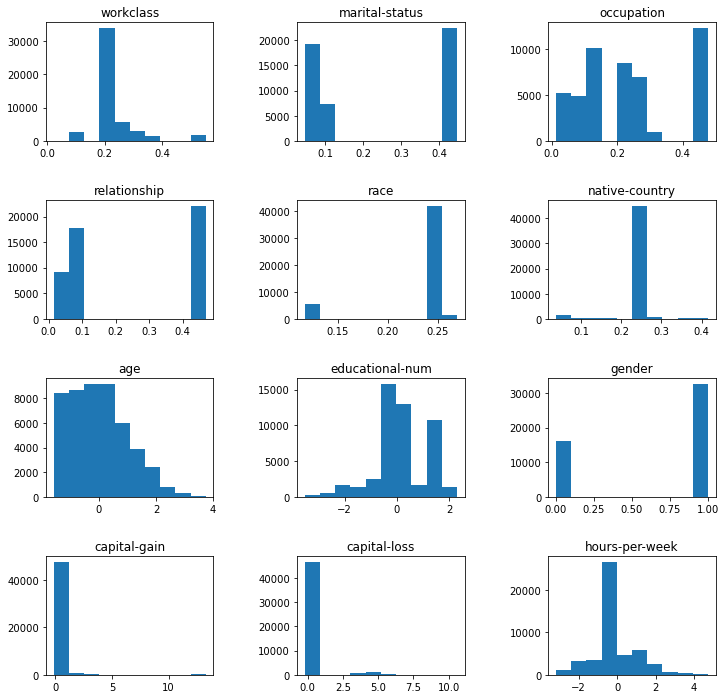

In [25]:
plt.figure(figsize=(12,12))
plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.subplot(4, 3, 1)
plt.title('workclass')
plt.hist(data['workclass'])
plt.subplot(4, 3, 2)
plt.title('marital-status')
plt.hist(data['marital-status'])
plt.subplot(4, 3, 3)
plt.title('occupation')
plt.hist(data['occupation'])
plt.subplot(4, 3, 4)
plt.title('relationship')
plt.hist(data['relationship'])
plt.subplot(4, 3, 5)
plt.title('race')
plt.hist(data['race'])
plt.subplot(4, 3, 6)
plt.title('native-country')
plt.hist(data['native-country'])
plt.subplot(4, 3, 7)
plt.title('age')
plt.hist(data['age'])
plt.subplot(4, 3, 8)
plt.title('educational-num')
plt.hist(data['educational-num'])
plt.subplot(4, 3, 9)
plt.title('gender')
plt.hist(data['gender'])
plt.subplot(4, 3, 10)
plt.title('capital-gain')
plt.hist(data['capital-gain'])
plt.subplot(4, 3, 11)
plt.title('capital-loss')
plt.hist(data['capital-loss'])
plt.subplot(4, 3, 12)
plt.title('hours-per-week')
plt.hist(data['hours-per-week'])

plt.show

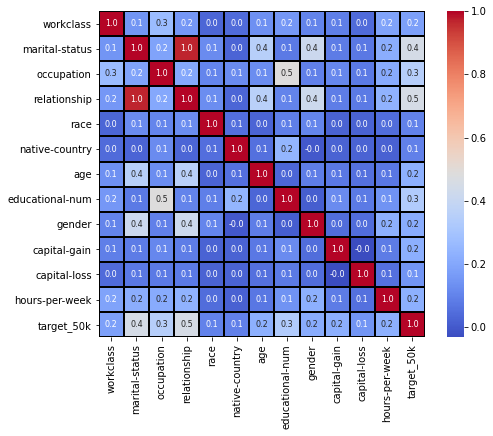

In [26]:
plt.figure(figsize=(8, 6))
sns.heatmap(data.corr(), cmap= 'coolwarm', linewidths=1, fmt='.1f', annot=True, linecolor='black', square=True, annot_kws={'size':8})
plt.show()

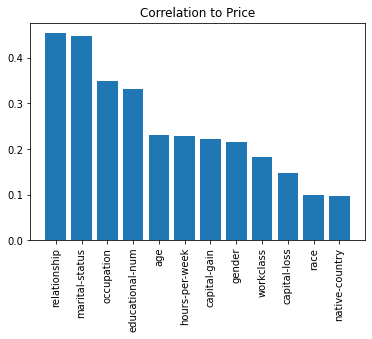

In [27]:
corrmat = data.loc[:].corrwith(
    data['target_50k']).abs().sort_values(ascending=False)[1:]
plt.bar(corrmat.index, corrmat.values)
plt.title('Correlation to Price')
plt.xticks(rotation='vertical')
plt.show()

## 5. Моделирование<a class='anchor' id='models'>

In [28]:
results_all = {}

In [29]:
features = list(data)[:12]
target = list(data)[12]

In [30]:
X = data[features]
y = data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=42)

In [31]:
log_regr = LogisticRegression(random_state = 42)
adaboost = AdaBoostClassifier(n_estimators=100)
gboost = GradientBoostingClassifier(n_estimators=100)
rand_forrest = RandomForestClassifier(n_estimators=25)
d_tree = DecisionTreeClassifier(max_depth=5)
mlp_class = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)

In [32]:
mlp_class.fit(X_train, y_train)
preds_mlp_class = mlp_class.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, preds_mlp_class)
fscore = (2 * precision * recall) / (precision + recall)

ix = np.argmax(fscore)

results_all['mlp_class'] = [thresholds[ix], fscore[ix], precision[ix], recall[ix], 
                           roc_auc_score(y_test, preds_mlp_class), r2(y_test, preds_mlp_class)]

C:\Users\artemiyb1\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [33]:
log_regr.fit(X_train, y_train)

preds_log_regr = log_regr.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, preds_log_regr)
fscore = (2 * precision * recall) / (precision + recall)

ix = np.argmax(fscore)

results_all['log_regr'] = [thresholds[ix], fscore[ix], precision[ix], recall[ix], 
                           roc_auc_score(y_test, preds_log_regr), r2(y_test, preds_log_regr)]

In [34]:
adaboost.fit(X_train, y_train)

preds_adaboost = adaboost.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, preds_adaboost)
fscore = (2 * precision * recall) / (precision + recall)

ix = np.argmax(fscore)

results_all['adaboost'] = [thresholds[ix], fscore[ix], precision[ix], recall[ix], 
                           roc_auc_score(y_test, preds_adaboost), r2(y_test, preds_log_regr)]

C:\Users\artemiyb1\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


In [35]:
gboost.fit(X_train, y_train)

preds_gboost = gboost.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, preds_gboost)
fscore = (2 * precision * recall) / (precision + recall)

ix = np.argmax(fscore)

results_all['gboost'] = [thresholds[ix], fscore[ix], precision[ix], recall[ix], 
                         roc_auc_score(y_test, preds_gboost), r2(y_test, preds_log_regr)]

In [36]:
rand_forrest.fit(X_train, y_train)

preds_rand_forrest = rand_forrest.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, preds_rand_forrest)
fscore = (2 * precision * recall) / (precision + recall)

ix = np.argmax(fscore)

results_all['rand_forrest'] = [thresholds[ix], fscore[ix], precision[ix], recall[ix], 
                               roc_auc_score(y_test, preds_rand_forrest), r2(y_test, preds_log_regr)]

In [37]:
d_tree.fit(X_train, y_train)

preds_d_tree = rand_forrest.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, preds_d_tree)
fscore = (2 * precision * recall) / (precision + recall)

ix = np.argmax(fscore)

results_all['d_tree'] = [thresholds[ix], fscore[ix], precision[ix], recall[ix], 
                         roc_auc_score(y_test, preds_d_tree), r2(y_test, preds_log_regr)]

In [38]:
def results(data_res):
    df = pd.DataFrame(data_res).T
    df.columns=['Best Threshold', 'F-Score', 'Precision', 'Recall', 'roc_auc_score', 'R_2']
    return df

In [39]:
results(results_all)

,Best Threshold,F-Score,Precision,Recall,roc_auc_score,R_2
mlp_class,0.336262,0.685478,0.609547,0.783019,0.905881,0.433699
log_regr,0.306048,0.674246,0.604913,0.761530,0.899577,0.414067
adaboost,0.498318,0.706998,0.652270,0.771751,0.917647,0.414067
gboost,0.377413,0.714066,0.698496,0.730346,0.920560,0.414067
rand_forrest,0.368000,0.676587,0.642185,0.714885,0.891043,0.414067
d_tree,0.368000,0.676587,0.642185,0.714885,0.891043,0.414067


**Вывод**

Выбираем gboost

## 6. Pipeline<a class='anchor' id='pipeline'>

In [40]:
#загружаем наш исходник
data = 'Dataset.data'
df = pd.read_csv(data, sep=' ')

In [41]:
#сразу делаем валидационную выборку с исходника, которую будем потом проверять по пайплайну
df_valid = df.sample(frac=0.65)

df_valid_x = df_valid.iloc[:,:-1]
df_valid_y = df_valid.iloc[:,-1]

df_valid_x.to_csv('df_valid_x.csv', index=None)
df_valid_y.to_csv('df_valid_y.csv', index=None)

In [42]:
df_valid.head()

,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0.1,40,United-States,<=50K
12380,25,Private,266600,HS-grad,9,Married-civ-spouse,Adm-clerical,Husband,Black,Male,3137,0,40,United-States,<=50K
27160,25,Private,164938,HS-grad,9,Never-married,Machine-op-inspct,Own-child,White,Male,4416,0,40,United-States,<=50K
21386,57,Private,109638,Some-college,10,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,1672,45,United-States,<=50K
37758,57,Private,548256,12th,8,Married-civ-spouse,Adm-clerical,Husband,Black,Male,0,0,40,United-States,<=50K
18031,38,Private,304651,HS-grad,9,Divorced,Transport-moving,Not-in-family,White,Male,0,0,60,United-States,<=50K


In [43]:
#обработка признаков в пайплайне 

class DFProcessing(TransformerMixin, BaseEstimator):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X.columns=["age", "workclass", "fnlwgt", "education", "educational-num", "marital-status", "occupation", "relationship", 
            "race", "gender", "capital-gain", "capital-loss", "hours-per-week", "native-country"]

        # пол
        X.loc[(X['gender'] == 'Male'), 'gender'] = 1
        X.loc[(X['gender'] == 'Female'), 'gender'] = 0
        X['gender'] = X['gender'].astype(np.float32)
        
        # text
        X_cbe = cbe_encoder.transform(X[["workclass", "marital-status", "occupation", "relationship", "race", "native-country"]])
        
        # data_itog
        X_data = X_cbe.join(X[["age", "educational-num", "gender", "capital-gain", 
                     "capital-loss", "hours-per-week"]])
        
        X_data[['age', 'educational-num', 'capital-gain', 'capital-loss', 'hours-per-week']] = scaler.fit_transform(X_data[['age', 'educational-num', 'capital-gain', 'capital-loss', 'hours-per-week']])
        
        return X_data


In [44]:
steps = [('transformfeatures', DFProcessing()), ('gboost', gboost)]
pipeline = Pipeline(steps)

In [45]:
predictions = pipeline.predict_proba(df_valid_x)
pd.DataFrame({'preds': predictions[:, 1]}).to_csv("test_predictions.csv", index=None)

In [46]:
#проверка трансормации пайплайна
data_check = pipeline[0].transform(df_valid_x)

In [47]:
data_check.head()

,workclass,marital-status,occupation,relationship,race,native-country,age,educational-num,gender,capital-gain,capital-loss,hours-per-week
12380,0.217874,0.446123,0.136892,0.448661,0.120862,0.243982,-0.994734,-0.417487,1.0,0.280813,-0.216675,-0.036650
27160,0.217874,0.045495,0.123176,0.014673,0.253987,0.243982,-0.994734,-0.417487,1.0,0.454575,-0.216675,-0.036650
21386,0.217874,0.446123,0.477779,0.448661,0.253987,0.243982,1.338656,-0.027619,1.0,-0.145372,3.947964,0.367859
37758,0.217874,0.446123,0.136892,0.448661,0.120862,0.243982,1.338656,-0.807355,1.0,-0.145372,-0.216675,-0.036650
18031,0.217874,0.101182,0.204261,0.101418,0.253987,0.243982,-0.046794,-0.417487,1.0,-0.145372,-0.216675,1.581388


In [48]:
roc_auc_score(y_score=predictions[:, 1][:], y_true=df_valid_y)

0.9197073828083849

In [49]:
with open("gboost_pipeline.dill", "wb") as f:
    dill.dump(pipeline, f)

## 7. Проверка Pipeline<a class='anchor' id='check'>

In [50]:
with open('gboost_pipeline.dill', 'rb') as in_strm:
    pipeline = dill.load(in_strm)

In [51]:
data = 'Dataset.data'
df = pd.read_csv(data, sep=' ')

df_valid = df.sample(frac=0.5)

df_valid_x = df_valid.iloc[:,:-1]
df_valid_y = df_valid.iloc[:,-1]

In [52]:
predictions = pipeline.predict_proba(df_valid_x)
pd.DataFrame({'preds': predictions[:, 1]}).to_csv("test_predictions.csv", index=None)

In [53]:
roc_auc_score(y_score=predictions[:, 1][:], y_true=df_valid_y)

0.9202694548054089

In [54]:
df_valid_x.head(1)

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country
37309,45,Private,126141,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,1.0,0,0,40,United-States


In [55]:
pipeline[0].transform(df_valid_x).head(1)

,workclass,marital-status,occupation,relationship,race,native-country,age,educational-num,gender,capital-gain,capital-loss,hours-per-week
37309,0.217874,0.446123,0.477779,0.448661,0.253987,0.243982,0.46459,1.132552,1.0,-0.145335,-0.21753,-0.035644


## 8. Проверка API Pipeline<a class='anchor' id='apicheck'>

In [56]:
from urllib import request, parse

X_test = pd.read_csv("df_valid_x.csv")
y_test = pd.read_csv("df_valid_y.csv")

In [57]:
import urllib.request
import json      

def get_prediction(age, workclass, fnlwgt, education, educational_num, marital_status, occupation, relationship, race, gender, capital_gain, capital_loss, hours_per_week, native_country):
    body = {'age': age, 'workclass': workclass, 'fnlwgt': fnlwgt, 
            'education': education, 'educational-num': educational_num, 'marital-status': marital_status, 
            'occupation': occupation, 'relationship': relationship, 'race': race, 'gender': gender, 
           'capital-gain': capital_gain, 'capital-loss': capital_loss, 'hours-per-week': hours_per_week, 
            'native-country': native_country} 

    myurl = "http://localhost:8080/predict"
    req = urllib.request.Request(myurl)
    req.add_header('Content-Type', 'application/json; charset=utf-8')
    jsondata = json.dumps(body)
    jsondataasbytes = jsondata.encode('utf-8')   # needs to be bytes
    req.add_header('Content-Length', len(jsondataasbytes))
    #print (jsondataasbytes)
    response = urllib.request.urlopen(req, jsondataasbytes)
    return json.loads(response.read())['predictions']

In [58]:
get_prediction('34', 'Private', '226443', 'HS-grad', '9', 'Divorced', 'Adm-clerical', 'Own-child', 'White', '1.0', '0', '0', '40', 'United-States')

URLError: <urlopen error [WinError 10061] Подключение не установлено, т.к. конечный компьютер отверг запрос на подключение>